## Summary

This notebook allows us to manually flag clustered items by signature string which breaks down the problem a little bit more. We can do this iteratively with EDA--send the results of the manual labeling back to EDA and try to find more clusters with the manually flagged clusters removed.

As stated in the previous notebook, the point here isn't to exhaustively catch all clusters with 'signature strings', we just want to cut the problem down to size so we can apply HDBSCAN and systematically 'cluster' the rest of the text. Use the term 'cluster' loosely here -- see summary of next notebook  (proc_17_108_analysis_jeffykao_HDBScan_Clustering).

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 500

In [2]:
%%time
data = pd.read_csv('proc_17_108_unique_comments_text_dupe_count.csv')
print(f"Loaded in {len(data)} entries aggregating {data['dupe_count'].sum()} total comments.")

Loaded in 2955186 entries aggregating 22078910.0 total comments.
CPU times: user 20 s, sys: 1.28 s, total: 21.3 s
Wall time: 22.7 s


In [3]:
# drop na's
data.dropna(axis=0, how='any', subset=['text_data'], inplace=True)
data.reset_index(inplace=True, drop=True)

# initially unclustered
data['level_0_cluster'] = -1

print(f"{len(data)} Text entries aggregating {data['dupe_count'].sum()} total comments.")

2955182 Text entries aggregating 22078856.0 total comments.


In [4]:
### slight detour ###
# curious about the top duplicated comments (without any clustering)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
### look at most and least duplicated comments
data_by_dupe = data.sort_values('dupe_count', ascending=False).reset_index(drop=True)
data_by_dupe.loc[:,['dupe_count','text_data']]

,dupe_count,text_data
0,1096832.0,"In 2015, Chairman Tom Wheelers Federal Communications Commission (FCC) imposed restrictive Title II, utility-style regulations under the guise of an open internet. Not only have these regulations inhibited innovation in the internet ecosystem, they hurt taxpayers and consumers by expanding the regulatory reach of the FCC and limiting investment in internet infrastructure. We cannot allow this revolutionary tool to be bogged down with excessive government interference.\n \nIt is past time ..."
1,817622.0,"The unprecedented regulatory power the Obama Administration imposed on the internet is smothering innovation, damaging the American economy and obstructing job creation.\n\nI urge the Federal Communications Commission to end the bureaucratic regulatory overreach of the internet known as Title II and restore the bipartisan light-touch regulatory consensus that enabled the internet to flourish for more than 20 years.\n\nThe plan currently under consideration at the FCC to repeal Obama's Title ..."
2,550000.0,"The current FCC regulatory scheme known as ""Title II"" represents an unprecedented increase in government control over the internet. Such over-regulation is hurting our economy and suffocating innovation.\n \nI support Chairman Pai's plan to return to a commonsense regulatory framework that allows for the internet to grow without useless government interference. The internet has flourished for decades without the heavy hand of government over-regulation. Its time we return to what works."
3,545551.0,"Before leaving office, the Obama Administration rammed through a massive scheme that gave the federal government broad regulatory control over the internet. That misguided policy decision is threatening innovation and hurting broadband investment in one of the largest and most important sectors of the U.S. economy.\n \nI support the Federal Communications Commission's decision to roll back Title II and allow for free market principles to guide our digital economy."
4,468436.0,"The Obama-era FCC regulations known as ""Title II"" enable the federal government to exert an extraordinary and unnecessary amount of regulatory control over the internet. This bureaucratic overreach impedes innovation, stifles investment and continues to create economic uncertainty for one of the largest sectors of the U.S. economy.\n \nI support Chairman Pai's proposal to roll back Title II and restore the sensible regulatory framework that enjoyed broad bipartisan consensus and enabled the ..."
5,451706.0,"The FCC's Open Internet Rules (net neutrality rules) are extremely important to me. I urge you to protect them.\n\nI don't want ISPs to have the power to block websites, slow them down, give some sites an advantage over others, or split the Internet into ""fast lanes"" for companies that pay and ""slow lanes"" for the rest.\n\nNow is not the time to let giant ISPs censor what we see and do online.\n\nCensorship by ISPs is a serious problem. Comcast has throttled Netflix, AT&T blocked FaceTime, T..."
6,422042.0,"As a concerned taxpayer and consumer, I am writing to urge the FCC to set the internet free and remove the inappropriate, unnecessary and overly vast regulations currently holding back the full potential of the internet. Due to the grip of the utility-style regulations imposed under the previous Commission, taxpayers have been put at risk, the threat of new fees on consumer bills still looms large, investment in internet infrastructure has not realized its full potential, innovations have go..."
7,379644.0,"Obama's Federal Communications Commission (FCC) forced regulations on the internet that put the government, and unaccountable bureaucrats, in control. These rules have cost taxpayers, slowed down broadband infrastructure investment, and hindered competition and choice for Americans. The time to remove the regulatory stranglehold on the internet is NOW.\n\nI urge the taxpayer-funded FCC to undo the ter

In [7]:
# eyeball above against a random sample
data_by_dupe.loc[:,['dupe_count','text_data']].sample(60)

,dupe_count,text_data
1513933,1.0,"I’m calling on the FCC to stand up for net neutrality and safeguard Title II protections. \r\n\r\nThe FCC should reject Chairman Ajit Pai’s proposal to hand the ISP monopolies like AT&T, Verizon, and Comcast the authority to throttle whatever they please, stripping consumers of the necessary access and privacy rules we worked for and so recently won. \r\n\r\nI’m worried about creating a tiered Internet with “fast lanes” for certain sites or services because Think about the big picture here. ..."
470814,2.0,"Mr Pai: I am concerned about Title 2 and net neutrality. I strongly implore the Federal Communications Commission to reverse President Obama's power grab to take over broadband. Americans, not the FCC, should be free to use whichever applications they desire. President Obama's power grab to take over broadband is a corruption of net neutrality. It disrupted a market-based policy that worked fabulously smoothly for two decades with bipartisan approval."
1805356,1.0,"I am writing in support of Net Neutrality rules. I make my living as a web developer. I remember specifically a time back in the age of dial-up, when I was working for a small privately-owned Internet Service Provider. When Verizon decided to start offering their own dial-up access product, the cost to maintain dial-up access points (i.e. virtual phone numbers people could use to dial in to access our internet service) rose dramatically. Perhaps it was coincidence, bue the bottom line is th..."
2887808,1.0,"Dear Commissioners: I want to give my opinion on net neutrality regulations. I would like to request the commission to repeal Obama's scheme to take over the Internet. Internet users, rather than the FCC, ought to purchase the products we want. Obama's scheme to take over the Internet is a perversion of net neutrality. It reversed a pro-consumer framework that functioned supremely smoothly for a long time with broad bipartisan consensus."
1997919,1.0,"To the Federal Communications Commission: I have concerns about the FCC regulations on the Internet. I advocate Ajit Pai to reverse President Obama's power grab to take over Internet access. People like me, as opposed to Washington bureaucrats, should use whichever services they desire. President Obama's power grab to take over Internet access is a exploitation of the open Internet. It disrupted a light-touch framework that functioned very well for many years with Republican and Democrat b..."
1782180,1.0,"I am an American citizen and voter. I appreciate that the FCC is inviting public comments on chairman Ajit Pai's intent to switch the legal regulation of the FCC from Title 2 to Title 1. I am writing to express my strong support for net neutrality , and I oppose the proposed switch to Title 1. \n\nThank you for considering my comments.\nMiranda Glasbergen"
1850861,1.0,"Mr Pai: With respect to the FCC's so-called Open Internet order. I recommend you to overturn Barack Obama's scheme to regulate Internet access. Individuals, as opposed to big government, should be able to purchase whatever products we desire. Barack Obama's scheme to regulate Internet access is a distortion of net neutrality. It reversed a hands-off approach that worked supremely well for a long time with both parties' backing."
1982121,1.0,"FCC commissioners, I have concerns about NET NEUTRALITY. I strongly advocate the Federal Communications Commission to overturn The Obama/Wheeler power grab to control broadband. People like me, as opposed to Washington, should be empowered to buy the applications they prefer. The Obama/Wheeler power grab to control broadband is a perversion of net neutrality. It reversed a pro-consumer policy that performed remarkably smoothly for a long time with bipartisan approval."
587944,2.0,"FCC commissioners, I'm concerned about NET NEUTRALITY. I would like to implore Chairman Pai to reverse Barack Obama's decision to regulate broadband. Individual citizens, as opposed to Washington, 

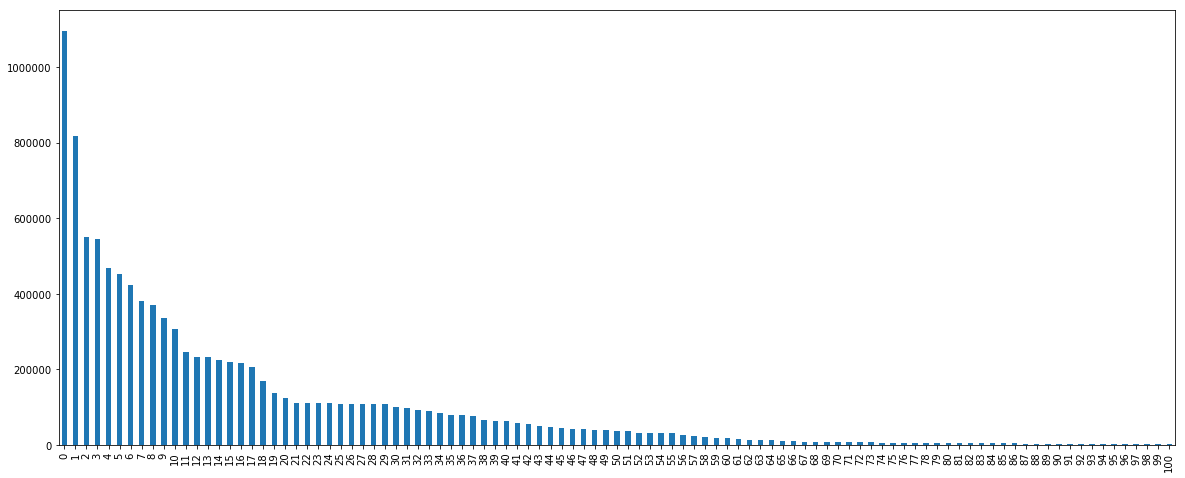

In [8]:
# quick plot of top 100 comments
plt.figure(1, figsize=(20, 8))
data_by_dupe.loc[:100,'dupe_count'].plot.bar()
plt.show()

In [9]:
### end detour ###

In [10]:
# some identified strings: you can add your own to the list below but it gets to be diminishing returns
# also be careful about adding strings that are too likely to appear naturally -- try to include some 'quirks' in the signature string
# this step is fairly manual and could definitely be better quantified but we accomplish the goal of cutting down our dataset

signature_strings_lists =\
[
    ["he FCC\'s Open Internet Rules (net neutrality rules) are extremely important to me","he FCC Open Internet Rules (net neutrality rules) are extremely important to me"],
    ["As an Internet user, I\'m asking the FCC to protect the net neutrality protections currently in place. \n\nThe FCC should throw out Chairman Ajit Pai\'s proposal to give the ISP monopolies like Comcast, AT&T, and Verizon the authority to create Internet fast lanes, stripping Internet users of the meaningful access and privacy protections we fought for and just recently won."],
    ["I am in favor of strong net neutrality under Title II of the Telecommunications Act.\n\n\nSincerely,\n"],
    ["Dear FCC Chairman Ajit Pai,\n\nI support the existing Net Neutrality rules, which classify internet service providers under the Title II provision of the Telecommunications Act. Please DO NOT roll back these regulations.\n\nSincerely,"],
    ["Dear Express Restoring Internet Freedom,"],
    ["As an Etsy seller, net neutrality is essential to the success of my business and my ability to care for myself and my family."],
    ["Net neutrality is shit because without it our ISPs will spy on us!"], #don't really get what these folks are getting at in this one :-/
    ["To whom it may concern:\nI would like my video comment at the following URL to be considered for the record.\n\nhttp://video.battleforthenet.com/player/#"],
    ["Net neutrality is a vital principle in a democratic society. The biggest losers under Chairman Pai's proposal are independent news outlets, small businesses, start-up blogs, grassroots activist groups...and everyone who uses the internet. And we won't stay quiet while mega-corporations gain control over the information we consume every day."],
    ["I am in favor of strong net neutrality under Title II of the Telecommunications Act. Sincerely,"],
    ['The Obama-era FCC regulations known as "Title II" enable the federal government to exert an extraordinary and unnecessary amount of regulatory control over the internet. This bureaucratic overreach impedes innovation, stifles investment and continues to create economic uncertainty for one of the largest sectors of the U.S. economy.\n \n I support Chairman Pai\'s proposal to roll back Title II and restore the sensible regulatory framework that enjoyed broad bipartisan consensus and enabled the internet to thrive for more than two decades.\n \n I strongly urge all of the FCC Commissioners to support the Chairman\'s proposal to repeal the harmful Title II internet takeover.'],
    ["Cable and phone companies provide access to the internet. They're telecommunications carriers. They do not (and should not) have the right to censor or slow down my speech and my access to online content."],
    ["The FCC's job is to stand up for consumers, not big cable companies."]
]

In [11]:
%%time
## flag by signature string one in the list is a positive match
for clusterid, signature_strings_list in enumerate(signature_strings_lists):
    masks = []
    for signature_string in signature_strings_list:
        masks.append(data['text_data'].str.contains(signature_string, regex=False))
    ##flag the dataframe with signature string
    ##first combine masks
    mask = masks[0]
    if len(masks) > 1:
        for t_mask in masks[1:]:
            mask = mask | t_mask
    data.loc[mask,'level_0_cluster'] = clusterid

CPU times: user 31.9 s, sys: 0 ns, total: 31.9 s
Wall time: 32 s


In [12]:
# after a lot of digging and iterations through the EDA I was able to pick out 2 mad-libs
# these are the most egregious examples that appear on their face to be bot campaigns, by text alone
regex_dicts = [
    {
        'a':r"(My comments re:|I'm concerned about|Hi, I'd like to comment on|With respect to|I'm very worried about|Regarding|I have thoughts on|I want to give my opinion on|I'm a voter worried about|I am a voter worried about|In the matter of|I'm contacting you about|I would like to comment on|I want to give my opinion on|I'd like to share my thoughts on|I'm very concerned about|I am concerned about|I have concerns about|In reference to|With respect to) (the FCC's so-called Open Internet order\.|Net Neutrality and Title II\.|net neutrality and Title II\.|the Open Internet order\.|restoring Internet freedom\.|an open Internet\.|Network Neutrality\.|the FCC's Open Internet order\.|network neutrality regulations\.|Internet regulation\.|Internet regulation and net neutrality\.|net neutrality regulations\.|Internet freedom\.|net neutrality rules\.|Net neutrality\.|internet regulations\.|Title 2 and net neutrality\.|net neutrality\.|regulations on the Internet\.|the Obama takeover of the Internet\.|the FCC rules on the Internet\.|the FCC regulations on the Internet\.|Internet Freedom\.|the future of the Internet\.|Title II rules\.|NET NEUTRALITY\.) ",
        'b':r"I( strongly|'d like to| want to| would like to|) (encourage|recommend|demand|suggest|advocate|ask|implore|request|urge) (the Federal Communications Commission|Chairman Pai|the commission|the commissioners|the FCC|you|the government|Ajit Pai|) to (undo|repeal|rescind|overturn|reverse|) (Barack Obama's|President Obama's|The previous administration's|Obama's|The Obama\/Wheeler|Tom Wheeler's|) (order|plan|scheme|power grab|decision|policy) to (take over|regulate|control|) (the Internet|Internet access|broadband|the web)\.",
        'c':r"(Individual Americans|Individuals|Americans|Citizens|Internet users|Individual citizens|People like me|), (rather than|as opposed to|not) (so-called experts|the FCC|big government|unelected bureaucrats|Washington|Washington bureaucrats|the FCC Enforcement Bureau|), ((deserve|should be empowered|should be able|should be free|ought) to|(should)) (enjoy|use|purchase|buy|select) (whatever|whichever|the|which) (services|products|applications) (we|they) (prefer|want|choose|desire)\.",
        'd':r"(Barack Obama's|President Obama's|The previous administration's|Obama's|The Obama\/Wheeler|Tom Wheeler's|) (order|plan|scheme|power grab|decision|policy) to (take over|regulate|control|) (the Internet|Internet access|broadband|the web) is a (corruption|betrayal|perversion|exploitation |distortion) of (the open Internet|net neutrality)\.",
        'e':r"It (reversed|stopped|disrupted|broke|ended|undid) a (hands-off|free-market|pro-consumer|market-based|light-touch) (framework|approach|system|policy) that (worked|functioned|performed) (remarkably|supremely|very|very, very|exceptionally|fabulously|) (smoothly|successfully|well) for (many years|a long time|decades|two decades) with (bipartisan|Republican and Democrat|nearly universal|both parties'|broad bipartisan) (approval|backing|consensus|support)\."
    },
    {
        'a':r"(The FCC should safeguard Internet freedom by keeping the bright-line net neutrality protections in place and upholding Title II\.|The FCC should ensure a fair and open Internet for all by opposing efforts to undermine net neutrality\.|I’m calling on the FCC to stand up for net neutrality and safeguard Title II protections\.|The FCC needs to stand up for Internet users like me and keep the net neutrality rules that are already in effect\.|The FCC must protect the open Internet by maintaining net neutrality protections under Title II\.|The FCC should stand up for Internet users by safeguarding net neutrality\.|We need the FCC to defend the rights of millions of Internet users by upholding net neutrality protections\.|As an Internet user, I’m asking the FCC to protect the net neutrality protections currently in place\.)",
        'b':r"The FCC should (reject|throw out) Chairman Ajit Pai’s (proposal|plan) to (give|hand) (the telecom giants|the (government-subsidized |)telecom giants|the (government-subsidized |)ISP monopolies) like ( |)(AT&T|Verizon|Comcast), ( |)(AT&T|Verizon|Comcast), and ( |)(AT&T|Verizon|Comcast) (free rein|the authority|the legal cover) to (engage in data discrimination|throttle whatever they please|create Internet fast lanes), stripping (Internet users|consumers|users) of the (necessary|meaningful|vital) (access and privacy|privacy and access) (rules|protections|safeguards|) we (demanded|worked for|fought for) and (so recently won|won just two years ago|just recently won)\.",
        'c':r"I’m (afraid of|worried about|concerned about) (a “pay-to-play” Internet where ISPs can charge more for certain websites|ISPs being allowed to discriminate against certain types of data or websites|creating a tiered Internet with “fast lanes” for certain sites or services) because ([Uu]sers will have fewer options and a less diverse Internet|ISPs could have too much power to determine what I can do online|the rich want to get richer, and you're enabling them if you slash current FCC rules|it further increases the power of the already monolithic corporations with monopolies on almost all of the ISP market)\.",
        'd':r"Thankfully, the (existing|current) (FCC regulations|Open Internet rules|net neutrality rules) (mean|ensure) that (ISP monopolies|Internet providers|ISPs) can’t (block or slow|slow or block) (customers’|our|users’|Internet users’|consumers’) (access|ability) to (see certain|certain) (web services|websites) or (create Internet “fast lanes”|engage in data discrimination) by charging (online services and websites|websites and online services|websites and online service) (money|more money) to reach (people|consumers|customers) faster\.",
        'e':r"(Thank you for keeping Title II net neutrality rules in place to protect Internet users like me\.|I appreciate you maintaining Title II net neutrality rules and the rights of Internet users like me\.|I urge you to keep Title II net neutrality in place, and safeguard Internet users like me\.|Thanks for protecting Internet users like me by upholding the existing Title II net neutrality rules\.)"
    }
]

In [13]:
%%time
regex_score_threshholds = [2, 2]
for index, regex_dict in enumerate(regex_dicts):
    print(f"Processing Regex{index}...")
    ## process the next regex list
    cols = []
    for col, regex in regex_dict.items():
        cols.append(data['text_data'].str.contains(regex))
    df_masks = (pd.concat(cols, axis=1).sum(axis=1) > regex_score_threshholds[index])
    next_clusterid = data['level_0_cluster'].max()+1
    data.loc[df_masks,'level_0_cluster'] = next_clusterid

Processing Regex0...


/home/jeff/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


Processing Regex1...
CPU times: user 4min 31s, sys: 56 ms, total: 4min 31s
Wall time: 4min 31s


In [14]:
#take another peek
data.sample(50)

,docid,text_data,dupe_count,level_0_cluster
2628575,10379194,"The FCC's Open Internet Rules (net neutrality rules) are extremely important to me. I urge you to protect them.\n\nI don't want ISPs to have the power to block websites, slow them down, give some sites an advantage over others, or split the Internet into ""fast lanes"" for companies that pay and ""slow lanes"" for the rest.\n\nNow is not the time to let giant ISPs censor what we see and do online.\n\nCensorship by ISPs is a serious problem. Comcast has throttled Netflix, AT&T blocked FaceTime, T...",1.0,0
2353851,9005702,"Net Neutrality is important to me because without it, I may not be able to communicate with my friends and go on sites I enjoy. This whole ending Net Neutrality thing is bullshit.",1.0,-1
2451452,10132438,"The FCC's Open Internet Rules (net neutrality rules) are extremely important to me. I urge you to protect them.\n\nI don't want ISPs to have the power to block websites, slow them down, give some sites an advantage over others, or split the Internet into ""fast lanes"" for companies that pay and ""slow lanes"" for the rest.\n\nNow is not the time to let giant ISPs censor what we see and do online.\n\nCensorship by ISPs is a serious problem. Comcast has throttled Netflix, AT&T blocked FaceTime, T...",1.0,0
712851,2581090,"I am in favor of strong net neutrality under Title II of the Telecommunications Act.\n\n\nSincerely,\nThomas Shaw",1.0,2
1403315,3939737,"Chairman Pai: Hi, I'd like to comment on Net Neutrality and Title II. I want to ask the Federal Communications Commission to undo Barack Obama's order to control the web. Internet users, not so-called experts, should buy which applications they choose. Barack Obama's order to control the web is a distortion of the open Internet. It stopped a hands-off approach that worked exceptionally smoothly for two decades with broad bipartisan consensus.",2.0,13
2429466,10102096,"The FCC's Open Internet Rules (net neutrality rules) are extremely important to me. I urge you to protect them.\r\n\r\nI don't want ISPs to have the power to block websites, slow them down, give some sites an advantage over others, or split the Internet into ""fast lanes"" for companies that pay and ""slow lanes"" for the rest.\r\n\r\nNow is not the time to let giant ISPs censor what we see and do online.\r\n\r\nCensorship by ISPs is a serious problem. Comcast has throttled Netflix, AT&T blocked...",1.0,0
40919,95227,"ISPs must remain under Title 2. Asking companies to obey the spirit of Net Neutrality without having a system of law to enforce Net Neutrality is a meaningless gesture that will negatively impact the American people. Infrastructure and ISPs in many areas of the country are natural monopolies, and when people can't realistically choose a vital service, then it is up to the government to ensure people are not taken advantage of by the providers of that vital service. The internet must remain a...",1.0,-1
334318,742599,you must preserve net neutrality and protect title 9. Open internet is a basic right for all of us. We need to be the standard setters for the world.,1.0,-1
544851,2200226,"FCC: I have concerns about net neutrality. I strongly implore the commissioners to repeal Tom Wheeler's policy to regulate the Internet. People like me, not unelected bureaucrats, should be able to buy whichever products they want. Tom Wheeler's policy to regulate the Internet is a betrayal of the open Internet. It stopped a free-market framework that functioned exceptionally successfully for two decades with bipartisan consensus.",2.0,13
65194,146327,"Preserve net neutrality under Title II regulation, please.",1.0,-1


In [15]:
#what's the document count for each cluster? 
doc_counts = data.groupby('level_0_cluster').sum()['dupe_count']
doc_counts

level_0_cluster
-1     11033922.0
 0      1571457.0
 1       166295.0
 2      7542184.0
 3         5068.0
 4         8591.0
 5        18922.0
 6         5175.0
 7          526.0
 8        47642.0
 9          237.0
 10         793.0
 11      169987.0
 12       20904.0
 13     1384868.0
 14      102285.0
Name: dupe_count, dtype: float64

In [16]:
#save to file so we can iterate it back to EDA or proceed to HDBSCAN

In [17]:
data.to_csv('proc_17_108_unique_comments_text_dupe_count_leveled.csv', index=False)